In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import networkx as nx
import random
from skimage.util import view_as_blocks
import queue
from tqdm.notebook import tqdm
from time import sleep
import math
import random

In [296]:
N_PROBES = 100
N_ITERATIONS = 1000
PATCH_SIZE = [64,64]
STOCHASTIC_SAMPLING = 0

sense_distance = 1.0
sense_angle = 2.5
step_size = 0.1
steering_rate = 0.5

In [297]:
TRACE_PATH = 'trace.npy'

print('Number of probes:', N_PROBES)
print('Patch Size:', PATCH_SIZE)

Number of probes: 100
Patch Size: [64, 64]


In [313]:
def probe_propogation(TRACE_PATH, N_ITERATIONS, N_PROBES, STOCHASTIC_SAMPLING, PATCH_SIZE, sense_distance, sense_angle, step_size, steering_rate):
    TRACE = np.load(TRACE_PATH)
    G = nx.Graph()
    patch = np.copy(TRACE[0:PATCH_SIZE[0],0:PATCH_SIZE[1],:])
    DOMAIN_SIZE = [PATCH_SIZE[0]-1,PATCH_SIZE[1]-1]
    
    probe_field = np.zeros((N_PROBES, 4))
    probe_field[:, 0] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[0], size=probe_field.shape[0])
    probe_field[:, 1] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[1], size=probe_field.shape[0])
    probe_field[:, 2] = default_rng().uniform(low=0.0, high=2.0*np.pi, size=probe_field.shape[0])
    probe_field[:, 3] = 1.0
    
    angle_queue = queue.Queue()
    pos_dict = {}
    node_id = 0
    
    def world_to_grid_2D(pos_world, size_world, size_grid):
        return (pos_world / size_world) * (size_grid)

    def angle_to_dir_2D(angle):
        return np.array([math.cos(float(angle)), math.sin(float(angle))])

    def custom_mod(a, b):
        return (a - b * math.floor(a / b))
    
    for i in tqdm(range(N_ITERATIONS)):
        probe_node_id = node_id
        for probe in range(probe_field.shape[0]):
            pos1, pos2, angle, weight = probe_field[probe]
            pos = [pos1, pos2]
            dir_fwd = angle_to_dir_2D(angle)
            angle_mut = angle + (random.random() - 0.5) * sense_angle
            dir_mut = angle_to_dir_2D(angle_mut)

            t_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
            t_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
            trace_fwd = (patch[t_fwd[0].astype(int)][t_fwd[1].astype(int)][0])
            trace_mut = (patch[t_mut[0].astype(int)][t_mut[1].astype(int)][0])

            angle_new = 0.0
            
            if STOCHASTIC_SAMPLING:
                if (random.random() < (0.5 * trace_fwd / (trace_fwd + trace_mut))):            
                    angle_new = (angle)  
                else:
                    angle_new = (steering_rate * angle_mut + (1.0-steering_rate) * angle)
            else:
                if (trace_fwd > trace_mut):
                    angle_new = (angle)
                else:
                    angle_new = (steering_rate * angle_mut + (1.0-steering_rate) * angle)

            if(G.number_of_nodes() == 0):
                G.add_node(probe_node_id)
                angle_queue.put(angle_new)
            else:
                if abs(angle_new - angle_queue.queue[0]) > 0.26:
                    G.add_node(probe_node_id)
                    G.add_edge(list(G.nodes())[-1], list(G.nodes())[-2])

                    if(angle_queue.qsize() == 3):
                        angle_queue.get()
                    angle_queue.put(angle_new)

            pos_dict[probe_node_id]=(pos1, pos2)
            dir_new = angle_to_dir_2D(angle_new)
#             dir_new = (angle_to_dir_2D(angle) + angle_to_dir_2D(angle_new)) / 2
#             dir_new = np.minimum(angle_to_dir_2D(angle), angle_to_dir_2D(angle_new))
            pos_new = pos + step_size * dir_new

            pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
            pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

            probe_field[probe][0] = pos_new[0]
            probe_field[probe][1] = pos_new[1]
            probe_field[probe][2] = angle_new
            probe_node_id = probe_node_id + 1
        node_id = node_id + probe_node_id
        
    patch_underlay = np.rot90(patch[:,:,0])
    patch_underlay = np.flipud(patch_underlay)
    print(angle_new)
    print(angle_queue.queue[0])
    return G, patch_underlay, pos_dict

In [314]:
graph, patch, positions = probe_propogation(TRACE_PATH, N_ITERATIONS, N_PROBES, STOCHASTIC_SAMPLING, PATCH_SIZE, sense_distance, sense_angle, step_size, steering_rate)


-26.859083056295013
-19.28580121597905


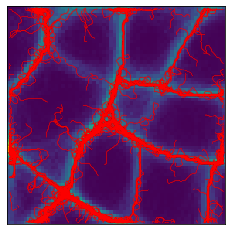

In [315]:
plt.imshow(patch)
# nx.draw(G, pos=pos_dict,
#         arrowstyle='->',
#         arrowsize=20,
#         width=0.01,
#         with_labels=False,
#         node_size=0.01,
#         node_color='red',
#         edge_color='blue')
nx.draw_networkx_nodes(graph, pos=positions,
        node_size=0.01, 
        node_color='red')
plt.savefig("0point5_trace_field.png", dpi=1000)

In [226]:
angle = 0.15

In [164]:
angle_mut = angle + (random.random() - 0.5) * sense_angle
angle_new = (steering_rate * angle_mut + ((1.0-steering_rate) * angle))

In [165]:
angle_new

-0.4132157292021378

In [308]:
TRACE = np.load(TRACE_PATH)
patch = np.copy(TRACE[0:PATCH_SIZE[0],0:PATCH_SIZE[1],:])

DOMAIN_SIZE = [PATCH_SIZE[0]-1,PATCH_SIZE[1]-1]

probe_field = np.zeros((N_PROBES, 4))
probe_field[:, 0] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[0], size=probe_field.shape[0])
probe_field[:, 1] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[1], size=probe_field.shape[0])
probe_field[:, 2] = default_rng().uniform(low=0.0, high=2.0*np.pi, size=probe_field.shape[0])
probe_field[:, 3] = 1.0
    

def world_to_grid_2D(pos_world, size_world, size_grid):
        return (pos_world / size_world) * (size_grid)
def angle_to_dir_2D(angle):
    return np.array([math.cos(float(angle)), math.sin(float(angle))])

pos1, pos2, angle, weight = probe_field[1]
pos = [pos1, pos2]
dir_fwd = angle_to_dir_2D(angle)
angle_mut = angle + (random.random() - 0.5) * sense_angle
dir_mut = angle_to_dir_2D(angle_mut)
        
t_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
t_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
trace_fwd = 0.5 * (patch[t_fwd[0].astype(int)][t_fwd[1].astype(int)][0])
trace_mut = patch[t_mut[0].astype(int)][t_mut[1].astype(int)][0]

In [309]:
trace_fwd

1.5757168531417847

In [310]:
trace_mut

5.125086

In [311]:
(2 * trace_fwd) / (trace_fwd + trace_mut)

0.4703068953049922

In [312]:
(1 * trace_fwd) / (trace_fwd + trace_mut)

0.2351534476524961

In [291]:
t_fwd

array([11.17861386,  0.39287507])

In [292]:
dir_fwd

array([ 0.37891597, -0.92543108])

In [293]:
dir_fwd_2 = np.array([0.1785, -0.3666])

In [294]:
dir_fwd_2

array([ 0.1785, -0.3666])

In [295]:
result = (dir_fwd + dir_fwd_2) / 2
result

array([ 0.27870798, -0.64601554])